# ESMPy Periodic Grid Test


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import ESMF

## Background
From [ESMPy documentation](http://www.earthsystemmodeling.org/esmf_releases/last_built/esmpy_doc/html/grid.html), we should be able to set periodic dimension
```
num_peri_dims (int) – The number of periodic dimensions, either 0 or 1. If None, defaults to 0.
periodic_dim (int) – The periodic dimension: 0, 1 or 2. If None, defaults to 0.
pole_dim (int) – The pole dimension 0 or 1. If None, defaults to 1.
```

## Make fake grid
Assume both input and output grids are periodic in longitude. Make sure to map the centers of the grid cells in both latitude and longitude.

In [2]:
lon_in = np.arange(-175, 175.1, 10)
lat_in = np.arange(-88, 88.1, 4)
lon_in, lat_in

(array([-175., -165., -155., -145., -135., -125., -115., -105.,  -95.,
         -85.,  -75.,  -65.,  -55.,  -45.,  -35.,  -25.,  -15.,   -5.,
           5.,   15.,   25.,   35.,   45.,   55.,   65.,   75.,   85.,
          95.,  105.,  115.,  125.,  135.,  145.,  155.,  165.,  175.]),
 array([-88., -84., -80., -76., -72., -68., -64., -60., -56., -52., -48.,
        -44., -40., -36., -32., -28., -24., -20., -16., -12.,  -8.,  -4.,
          0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.]))

In [3]:
lon_out = np.arange(-177.5, 177.5 + 0.1, 5)
lat_out = np.arange(-88, 88.1, 4)
lon_out, lat_out

(array([-177.5, -172.5, -167.5, -162.5, -157.5, -152.5, -147.5, -142.5,
        -137.5, -132.5, -127.5, -122.5, -117.5, -112.5, -107.5, -102.5,
         -97.5,  -92.5,  -87.5,  -82.5,  -77.5,  -72.5,  -67.5,  -62.5,
         -57.5,  -52.5,  -47.5,  -42.5,  -37.5,  -32.5,  -27.5,  -22.5,
         -17.5,  -12.5,   -7.5,   -2.5,    2.5,    7.5,   12.5,   17.5,
          22.5,   27.5,   32.5,   37.5,   42.5,   47.5,   52.5,   57.5,
          62.5,   67.5,   72.5,   77.5,   82.5,   87.5,   92.5,   97.5,
         102.5,  107.5,  112.5,  117.5,  122.5,  127.5,  132.5,  137.5,
         142.5,  147.5,  152.5,  157.5,  162.5,  167.5,  172.5,  177.5]),
 array([-88., -84., -80., -76., -72., -68., -64., -60., -56., -52., -48.,
        -44., -40., -36., -32., -28., -24., -20., -16., -12.,  -8.,  -4.,
          0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.]))

## Create Grid & Regrid object

In [4]:
sourcegrid = ESMF.Grid(np.array([lon_in.size, lat_in.size]), 
                       staggerloc = [ESMF.StaggerLoc.CENTER],
                       coord_sys = ESMF.CoordSys.SPH_DEG,
                       num_peri_dims = 1)

source_lon = sourcegrid.get_coords(0)
source_lat = sourcegrid.get_coords(1)

source_lon[...], source_lat[...] = np.meshgrid(lon_in, lat_in, indexing='ij')

In [5]:
sourcegrid.periodic_dim

0

In [6]:
destgrid = ESMF.Grid(np.array([lon_out.size, lat_out.size]), 
                       staggerloc = [ESMF.StaggerLoc.CENTER],
                       coord_sys = ESMF.CoordSys.SPH_DEG,
                       num_peri_dims = 1)


dest_lon = destgrid.get_coords(0)
dest_lat = destgrid.get_coords(1)

dest_lon[...], dest_lat[...] = np.meshgrid(lon_out, lat_out, indexing='ij')

In [7]:
sourcefield = ESMF.Field(sourcegrid)
destfield = ESMF.Field(destgrid)

In [8]:
regrid_bi = ESMF.Regrid(sourcefield, destfield, 
                        regrid_method = ESMF.RegridMethod.BILINEAR,  
                        unmapped_action = ESMF.UnmappedAction.ERROR)

## Make input data

In [9]:
wave = lambda x,k:  np.sin(x*k*np.pi/180.0)
sourcefield.data[...] = np.outer(wave(lon_in,3), wave(lat_in,3)) + 1

## Apply regridding

In [10]:
destfield = regrid_bi(sourcefield, destfield)

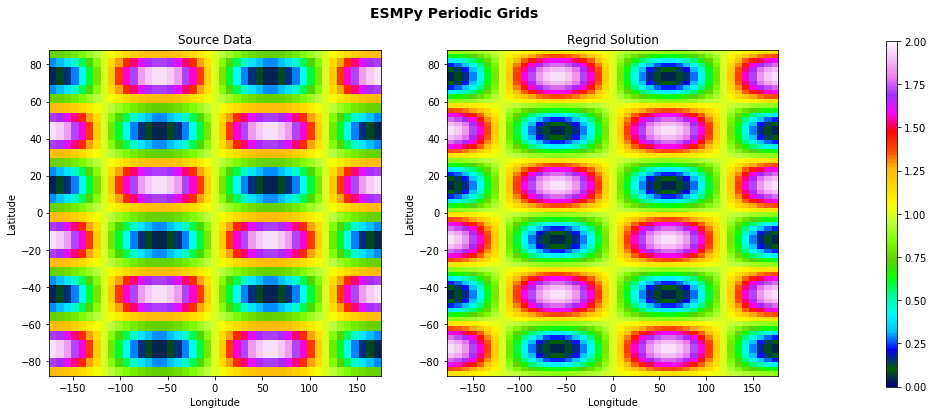

In [11]:
fig = plt.figure(1, (15, 6))
fig.suptitle('ESMPy Periodic Grids', fontsize=14, fontweight='bold')

ax = fig.add_subplot(1, 2, 1)
im = ax.imshow(sourcefield.data, vmin=0, vmax=2, cmap='gist_ncar', aspect='auto',
               extent=[min(lon_in), max(lon_in), min(lat_in), max(lat_in)])
ax.set_xbound(lower=min(lon_in), upper=max(lon_in))
ax.set_ybound(lower=min(lat_in), upper=max(lat_in))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Source Data")

ax = fig.add_subplot(1, 2, 2)
im = ax.imshow(destfield.data, vmin=0, vmax=2, cmap='gist_ncar', aspect='auto',
               extent=[min(lon_out), max(lon_out), min(lat_out), max(lat_out)])
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Regrid Solution")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.9, 0.1, 0.01, 0.8])
fig.colorbar(im, cax=cbar_ax)